## Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch import nn, optim
from transformers import BertTokenizer, BertForSequenceClassification
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

## Preprocessing

In [2]:
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [3]:
data_folder = 'data'
train_test_ratio = 0.8
train_valid_ratio = 0.8
first_n_words = 200

In [4]:
# Read raw data
df_raw = pd.read_csv(os.path.join(data_folder, 'news.csv'))

# Prepare columns
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + '. ' + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop(df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(
    df_real, train_size=train_test_ratio, random_state=1
)
df_fake_full_train, df_fake_test = train_test_split(
    df_fake, train_size=train_test_ratio, random_state=1
)

# Train-valid split
df_real_train, df_real_valid = train_test_split(
    df_real_full_train, train_size=train_valid_ratio, random_state=1
)
df_fake_train, df_fake_valid = train_test_split(
    df_fake_full_train, train_size=train_valid_ratio, random_state=1
)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(os.path.join(data_folder, 'train.csv'), index=False)
df_valid.to_csv(os.path.join(data_folder, 'valid.csv'), index=False)
df_test.to_csv(os.path.join(data_folder, 'test.csv'), index=False)

## Preliminaries

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Model parameter
Batch_Size = 16
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False,
                    batch_first=True)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False,
                   include_lengths=False, batch_first=True, fix_length=MAX_SEQ_LEN,
                   pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [
    ('label', label_field), ('title', text_field),
    ('text', text_field), ('titletext', text_field)
]

# TabularDataset
train, valid, test = TabularDataset.splits(
    path=data_folder, train='train.csv', validation='valid.csv',
    test='test.csv', format='CSV', fields=fields, skip_header=True
)

# Iterators
train_iter = BucketIterator(
    train, batch_size=Batch_Size, sort_key=lambda x: len(x.text),
    device=device, train=True, sort=True, sort_within_batch=True
)
valid_iter = BucketIterator(
    valid, batch_size=Batch_Size, sort_key=lambda x: len(x.text),
    device=device, train=True, sort=True, sort_within_batch=True
)
test_iter = Iterator(
    test, batch_size=Batch_Size, device=device, train=False, shuffle=False, sort=False
)

Token indices sequence length is longer than the specified maximum sequence length for this model (4230 > 512). Running this sequence through the model will result in indexing errors


## Models

In [8]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

## Training

In [9]:
# Save and Load Functions
def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return
    
    state_dict = {
        'model_state_dict': model.state_dict(),
        'valid_loss': valid_loss
    }
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])

    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    
    state_dict = {
        'train_loss_list': train_loss_list,
        'valid_loss_list': valid_loss_list,
        'global_steps_list': global_steps_list
    }
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):
    if load_path == None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return (
        state_dict['train_loss_list'],
        state_dict['valid_loss_list'],
        state_dict['global_steps_list']
    )

In [10]:
# Training Function
def train(model,
          optimizer,
          file_path,
          criterion=nn.BCELoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=5,
          eval_every=len(train_iter) // 2,
          best_valid_loss=float('Inf')):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            titletext = titletext.to(device)
            labels = labels.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        titletext = titletext.to(device)
                        labels = labels.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                # print progress
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Step [{global_step}/{num_epochs * len(train_loader)}], "
                    f"Train Loss: {average_train_loss:.4f}, "
                    f"Valid Loss: {average_valid_loss:.4f}"
                   )

                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(os.path.join(file_path, 'model.pt'),
                                    model, best_valid_loss)
                    save_metrics(os.path.join(file_path, 'metrics.pt'),
                                 train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(os.path.join(file_path, 'metrics.pt'),
                 train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [11]:
output_folder = 'model'
os.makedirs(output_folder, exist_ok=True)

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer, file_path=output_folder)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [126/1260], Train Loss: 0.5132, Valid Loss: 0.3603
Model saved to ==> model/model.pt
Model saved to ==> model/metrics.pt
Epoch [1/5], Step [252/1260], Train Loss: 0.1671, Valid Loss: 0.1711
Model saved to ==> model/model.pt
Model saved to ==> model/metrics.pt
Epoch [2/5], Step [378/1260], Train Loss: 0.1749, Valid Loss: 0.0931
Model saved to ==> model/model.pt
Model saved to ==> model/metrics.pt
Epoch [2/5], Step [504/1260], Train Loss: 0.0537, Valid Loss: 0.1553
Epoch [3/5], Step [630/1260], Train Loss: 0.0802, Valid Loss: 0.1578
Epoch [3/5], Step [756/1260], Train Loss: 0.0399, Valid Loss: 0.2105
Epoch [4/5], Step [882/1260], Train Loss: 0.0434, Valid Loss: 0.2633
Epoch [4/5], Step [1008/1260], Train Loss: 0.0286, Valid Loss: 0.1797
Epoch [5/5], Step [1134/1260], Train Loss: 0.0322, Valid Loss: 0.1831
Epoch [5/5], Step [1260/1260], Train Loss: 0.0579, Valid Loss: 0.2284
Model saved to ==> model/metrics.pt
Finished Training!


Model loaded from <== model/metrics.pt


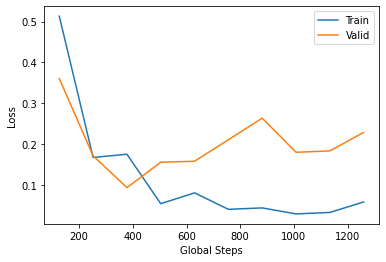

In [12]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(
    os.path.join(output_folder, 'metrics.pt')
)
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Evaluation

In [13]:
# Evaluation Function
def evaluate(model, test_loader):
    y_pred, y_true = [], []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)
            titletext = titletext.to(device)
            output = model(titletext, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1, 0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9684    0.9313    0.9495       626
           0     0.9347    0.9701    0.9521       635

    accuracy                         0.9508      1261
   macro avg     0.9516    0.9507    0.9508      1261
weighted avg     0.9515    0.9508    0.9508      1261



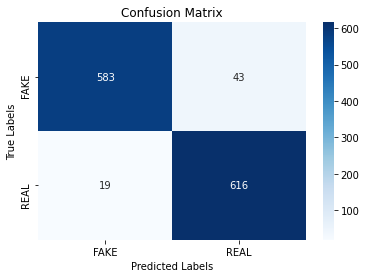

In [14]:
best_model = BERT().to(device)
load_checkpoint(os.path.join(output_folder, 'model.pt'), best_model)

evaluate(best_model, test_iter)